### Nikolaos Giannopoulos AM 5199
### Team: Trump Tariffed My Datasets

In [1]:
import networkx as nx
import csv
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import math
import torch
from tqdm import tqdm
from random import randint
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [2]:
#Create a graph
G = nx.read_edgelist('edgelist.txt', delimiter=',', create_using=nx.Graph(), nodetype=int)
diG = nx.read_edgelist('edgelist.txt', delimiter=',', create_using=nx.DiGraph(), nodetype=int)
nodes = list(G.nodes())
n = G.number_of_nodes()
m = G.number_of_edges()
print('Number of nodes:', n)
print('Number of edges:', m)


Number of nodes: 138499
Number of edges: 1091955


In [3]:
#Read the abstract of each paper
abstracts = dict()
with open('abstracts.txt', 'r', encoding='utf-8') as f:
    for line in f:
        node, abstract = line.split('|--|')
        abstracts[int(node)] = abstract

In [4]:
#Read the authors of each paper
authors = dict()
with open('authors.txt', 'r', encoding='utf-8') as f:
    for line in f:
        node, author = line.split('|--|')
        authors[int(node)] = author

# Load from files

In [5]:
with open("Data/authors_preprocessing.pkl", "rb") as f:
    authors_dict = pickle.load(f)

#Now I have access
print(authors_dict[0]) 

['james h niblock', 'jianxun peng', 'karen r mcmenemy', 'george w irwin']


In [6]:
with open("Data/abstracts_preprocessing.pkl", "rb") as f:
    abstracts_tokenized = pickle.load(f)

#Now I have access
print(abstracts_tokenized[0]) 

['development', 'automated', 'system', 'quality', 'assessment', 'aerodrome', 'ground', 'lighting', 'agl', 'accordance', 'associated', 'standard', 'recommendation', 'presented', 'system', 'composed', 'image', 'sensor', 'placed', 'inside', 'cockpit', 'aircraft', 'record', 'image', 'agl', 'normal', 'descent', 'aerodrome', 'modelbased', 'methodology', 'used', 'ascertain', 'optimum', 'match', 'template', 'agl', 'actual', 'image', 'data', 'order', 'calculate', 'position', 'orientation', 'camera', 'instant', 'image', 'acquired', 'camera', 'position', 'orientation', 'data', 'used', 'along', 'pixel', 'grey', 'level', 'imaged', 'luminaire', 'estimate', 'value', 'luminous', 'intensity', 'given', 'luminaire', 'compared', 'expected', 'brightness', 'luminaire', 'ensure', 'operating', 'required', 'standard', 'metric', 'quality', 'agl', 'pattern', 'determined', 'experiment', 'real', 'image', 'data', 'presented', 'demonstrate', 'application', 'effectiveness', 'system']


# Varius methods to add to training

In [7]:
epsilon = 1e-6
def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / ((magA * magB) + epsilon)

In [8]:
neighbor = nx.average_neighbor_degree(G)
pagerank = nx.pagerank(G)
triangles = nx.triangles(G)
cores = nx.core_number(G)
onions = nx.onion_layers(G)
clustering = nx.clustering(G)

# Trained SPECTER from files

In [11]:
article_textual_embeddings3 = torch.load(f'Data/article_textual_embeddings_specter_test.pt', weights_only=False)
npz_to_save = np.array(article_textual_embeddings3)
article_textual_embeddings_part1 = article_textual_embeddings3[:138499 // 2]
npz_to_save_1 = np.array(article_textual_embeddings_part1)
article_textual_embeddings_part2 = article_textual_embeddings3[138499 // 2:]
npz_to_save_2 = np.array(article_textual_embeddings_part2)
with open(f'Data/embeddings_part_1.npy', 'wb') as f:
    np.savez_compressed(f, npz_to_save_1)

with open(f'Data/embeddings_part_2.npy', 'wb') as f:
    np.savez_compressed(f, npz_to_save_2)
with open(f'Data/embeddings_best.npy', 'wb') as f:
    np.savez_compressed(f, npz_to_save)
    #np.save(f, npz_to_save)
with open(f'Data/embeddings_part_1.npy', 'rb') as f:
    article_textual_embeddings_part1 = np.load(f)
    part1 = article_textual_embeddings_part1['arr_0']

with open(f'Data/embeddings_part_2.npy', 'rb') as f:
    article_textual_embeddings_part2 = np.load(f)
    part2 = article_textual_embeddings_part2['arr_0']

full_array = np.concatenate((part1, part2), axis=0)

# Grapg Features

In [9]:
#Shortest Path
def shortest_path_length(G, n1, n2):
    try:
        length = nx.shortest_path_length(G, n1, n2)
    except:
        length = -1
    return length

#Adamic-Adar
def adamic_adar_index(G, n1, n2):
    try:
        coeff = list(nx.adamic_adar_index(G, [(n1, n2)]))[0][2]
        if np.isinf(coeff) or np.isnan(coeff):
            coeff = 0
        return coeff
    except:
        return 0

#Preferential Attachment
def pref_attachment(G, n1, n2):
    _, _, coeff = list(nx.preferential_attachment(G, [(n1, n2)]))[0]
    return coeff

#Common Neighbours
def common(G, n1, n2):
    common = len(set(G[n1]) & set(G[n2]))
    return common

#Salton index
def salton_index(G, n1, n2):
    sqrt_prod_deg = np.sqrt(G.degree(n1) * G.degree(n2))
    if sqrt_prod_deg == 0:
        return 0
    else:
        return len(list(nx.common_neighbors(G, n1, n2)))/sqrt_prod_deg

#Jaccard Coefficient
def jaccard_coefficient(G, n1, n2):
    _, _, coeff = list(nx.jaccard_coefficient(G, [(n1, n2)]))[0]
    return coeff

#Hub Depressed Index
def hub_depressed_index(G, n1, n2):
    max_deg = max(G.degree(n1), G.degree(n2))
    if max_deg == 0:
        return 0
    else:
        return len(list(nx.common_neighbors(G, n1, n2)))/max_deg

#Resource Allocation Index
def resource_allocation_index(G, n1, n2):
    _, _, coeff = list(nx.resource_allocation_index(G, [(n1, n2)]))[0]
    return coeff

# Feature enineering 

In [1]:
X_train = np.zeros((2*m, 22), dtype=np.float32)
y_train = np.zeros(2*m, dtype=np.float32)

specter_embeddings = np.load('Data/embeddings_best.npy')['arr_0']
embedding_dim = specter_embeddings.shape[1]

#Precompute degrees, authors, and abstracts once
node_degrees = dict(G.degree())
node_connectivity = {n: nx.average_degree_connectivity(G, nodes=n).get(node_degrees[n], 0) for n in G.nodes()}
node_authors = authors_dict
node_abstracts = abstracts_tokenized

n = G.number_of_nodes()
edges = list(G.edges())

for i, edge in tqdm(enumerate(edges), desc='Training', total=m):
    u, v = edge
    deg_u, deg_v = node_degrees[u], node_degrees[v]

    abs_u, abs_v = node_abstracts[u], node_abstracts[v]
    auth_u, auth_v = node_authors[u], node_authors[v]

    emb_u = specter_embeddings[u]
    emb_v = specter_embeddings[v]
    cos_sim = cosine_similarity([emb_u], [emb_v])[0][0]
    l2_dist = np.linalg.norm(emb_u - emb_v)

    
    degu, degv = G.degree(u), G.degree(v)

    
    
    X_train[i] = [
        len(abs_u) + len(abs_v), #(S) Abstract size 
        abs(len(abs_u) - len(abs_v)), #(D) Abstract size 
        len(set(abs_u).intersection(set(abs_v))), #Words in common
        
        len(auth_u) + len(auth_v), #(S) Authors size
        abs(len(auth_u) - len(auth_v)), #(D) Authors size
        len(set(auth_u).intersection(set(auth_v))), #Authors in common
        
        jaccard_coefficient(G, u, v), #Jaccard Similarity
        
        counter_cosine_similarity(Counter(abstracts_tokenized[u]), Counter(abstracts_tokenized[v])), #Cosine Similarity Abstracts
        counter_cosine_similarity(Counter(authors_dict[u]), Counter(authors_dict[v])), #Cosine Similarity Authors
        
        #neighbor[u] + neighbor[v], #(S) Avg neigh deg
        #abs(neighbor[u] - neighbor[v]), #(D) Avg neigh deg
        
        #pagerank[u] + pagerank[v], #(S) Pagerank
        #abs(pagerank[u] - pagerank[v]), #(D) Pagerank

        triangles[u] + triangles[v], #(S) Triangles
        abs(triangles[u] - triangles[v]), #(D) Triangles
        cores[u] + cores[v], #(S) Cores

        #onions[u] + onions[v], #(S) Onions
        #abs(onions[u] - onions[v]), #(D) Onions
        
        #clustering[u] + clustering[v], #(S) Clustering
        #abs(clustering[u] - clustering[v]), #(D) Clustering
        
        adamic_adar_index(G, u, v), #Academic Adar Index
        salton_index(G, u, v), #Salton index
        hub_depressed_index(G, u, v), #Hub Depressed Index
        resource_allocation_index(G, u, v), #Ressource Allocation Index
        pref_attachment(G, u, v),

        degu + degv, #(S) Degree
        abs(degu - degv), #(D) Degree

        cos_sim, #Specter Cosing
        l2_dist, #Specter distance
        common(G, u, v)
    ]
    y_train[i] = 1

    #Negative sample
    while True:
        n1, n2 = randint(0, n - 1), randint(0, n - 1)
        if not G.has_edge(n1, n2):
            break

    deg_n1, deg_n2 = node_degrees[n1], node_degrees[n2]
    abs_n1, abs_n2 = node_abstracts[n1], node_abstracts[n2]
    auth_n1, auth_n2 = node_authors[n1], node_authors[n2]
    emb_n1 = specter_embeddings[n1]
    emb_n2 = specter_embeddings[n2]
    degn1, degn2 = G.degree(n1), G.degree(n2)
    cos_sim = cosine_similarity([emb_n1], [emb_n2])[0][0]
    l2_dist = np.linalg.norm(emb_n1 - emb_n2)

    X_train[m+i] = [
        len(abs_n1) + len(abs_n2),
        abs(len(abs_n1) - len(abs_n2)),
        len(set(abs_n1).intersection(set(abs_n2))),
        
        len(auth_n1) + len(auth_n2),
        abs(len(auth_n1) - len(auth_n2)),
        len(set(auth_n1).intersection(set(auth_n2))), 
        
        jaccard_coefficient(G, n1, n2),
        counter_cosine_similarity(Counter(abstracts_tokenized[n1]), Counter(abstracts_tokenized[n2])),
        counter_cosine_similarity(Counter(authors_dict[n1]), Counter(authors_dict[n2])),
        
        
        #neighbor[n1] + neighbor[n2],
        #abs(neighbor[n1] - neighbor[n2]),
        
        #pagerank[n1] + pagerank[n2],
        #abs(pagerank[n1] - pagerank[n2]),
        
        triangles[n1] + triangles[n2],
        abs(triangles[n1] - triangles[n2]),
        cores[n1] + cores[n2],
        #onions[n1] + onions[n2],
        #abs(onions[n1] - onions[n2]),
        #clustering[n1] + clustering[n2],
        #abs(clustering[n1] - clustering[n2]),

        adamic_adar_index(G, n1, n2),
        salton_index(G, n1, n2),
        hub_depressed_index(G, n1, n2),
        resource_allocation_index(G, n1, n2),
        pref_attachment(G, n1, n2),
        
        degn1 + degn2, 
        abs(degn1 - degn2), 
        
        cos_sim,
        l2_dist,
        common(G, n1, n2)
    ]
    y_train[m+i] = 0

#Convert to torch tensors and move to GPU
X_train_tensor = torch.tensor(X_train).cuda()
y_train_tensor = torch.tensor(y_train).cuda()



KeyboardInterrupt: 

In [36]:
print('Size of training matrix:', X_train_tensor.shape)
print('Size of training matrix:', y_train_tensor.shape)
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)

Size of training matrix: torch.Size([2183910, 22])
Size of training matrix: torch.Size([2183910])


In [47]:
feature_names = [
    '(S) Abstract size', '(D) Abstract size', 'Words in common', '(S) Authors size', '(D) Authors size', 'Authors in common', 'Jaccard Similarity', 'Cosine Similarity Abstracts', 'Cosine Similarity Authors',
    '(S) Triangles', '(D) Triangles', '(S) Cores',
    'Adamic Adar Index', 'Salton index','Hub Depressed Index', 'Ressource Allocation Index','Pref attachment',

    
    
    '(S) Degree', '(D) Degree',  
    'Specter Cosing', 'Specter distance', 'Common'
]

In [48]:
df_train = pd.DataFrame(data = X_train, columns = feature_names)
df_train

,(S) Abstract size,(D) Abstract size,Words in common,(S) Authors size,(D) Authors size,Authors in common,Jaccard Similarity,Cosine Similarity Abstracts,Cosine Similarity Authors,(S) Triangles,...,Adamic Adar Index,Salton index,Hub Depressed Index,Ressource Allocation Index,Pref attachment,(S) Degree,(D) Degree,Specter Cosing,Specter distance,Common
0,157.0,15.0,2.0,7.0,1.0,1.0,0.000000,0.015683,0.288675,10.0,...,0.000000,0.000000,0.000000,0.000000,40.0,22.0,18.0,0.035296,33.075211,0.0
1,193.0,21.0,7.0,5.0,3.0,0.0,0.000000,0.199250,0.000000,25.0,...,0.000000,0.000000,0.000000,0.000000,78.0,41.0,37.0,0.214833,29.868652,0.0
2,182.0,40.0,11.0,7.0,1.0,0.0,0.000000,0.163964,0.000000,10.0,...,0.000000,0.000000,0.000000,0.000000,220.0,31.0,9.0,0.774988,16.014669,0.0
3,123.0,19.0,6.0,7.0,1.0,0.0,0.024390,0.087569,0.000000,29.0,...,0.339623,0.047673,0.045455,0.052632,440.0,42.0,2.0,0.570168,21.805489,1.0
4,134.0,8.0,21.0,6.0,0.0,1.0,0.083333,0.392619,0.333333,19.0,...,0.866944,0.153897,0.150000,0.100561,380.0,39.0,1.0,0.981855,4.559656,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183905,107.0,107.0,0.0,10.0,2.0,0.0,0.000000,0.000000,0.000000,8.0,...,0.000000,0.000000,0.000000,0.000000,16.0,10.0,6.0,0.019642,32.957195,0.0
2183906,195.0,97.0,2.0,4.0,2.0,0.0,0.000000,0.011527,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,2.0,3.0,1.0,-0.006113,33.610317,0.0
2183907,272.0,64.0,5.0,7.0,3.0,0.0,0.000000,0.024058,0.000000,28.0,...,0.000000,0.000000,0.000000,0.000000,36.0,20.0,16.0,-0.011698,33.317543,0.0
2183908,184.0,74.0,8.0,8.0,0.0,0.0,0.000000,0.114294,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,40.0,13.0,3.0,0.030015,32.991257,0.0


# Test matrix creation

In [13]:
#Read test data. Each sample is a pair of nodes
node_pairs = list()
with open('test.txt', 'r') as f:
    for line in f:
        t = line.split(',')
        node_pairs.append((int(t[0]), int(t[1])))

In [29]:
X_test = np.zeros((len(node_pairs), 22))
y_test = np.zeros((len(node_pairs)))

node_degrees = dict(G.degree())
node_connectivity = {n: nx.average_degree_connectivity(G, nodes=n).get(node_degrees[n], 0) for n in G.nodes()}
node_authors = authors_dict
node_abstracts = abstracts_tokenized

for i,node_pair in tqdm(enumerate(node_pairs), desc='Creating test matrix', total=len(node_pairs)):
        u = node_pair[0]
        v = node_pair[1]
        deg_u, deg_v = node_degrees[u], node_degrees[v]
        degu, degv = G.degree[u], G.degree[v]
        abs_u, abs_v = node_abstracts[u], node_abstracts[v]
        auth_u, auth_v = node_authors[u], node_authors[v]
    
        emb_u = specter_embeddings[u]
        emb_v = specter_embeddings[v]
        cos_sim = cosine_similarity([emb_u], [emb_v])[0][0]
        l2_dist = np.linalg.norm(emb_u - emb_v)
        
        
        
        X_test[i,0] =len(abs_u) + len(abs_v)
        X_test[i,1] =abs(len(abs_u) - len(abs_v))
        X_test[i,2] =len(set(abs_u).intersection(set(abs_v)))
        
        X_test[i,3] =len(auth_u) + len(auth_v)
        X_test[i,4] =abs(len(auth_u) - len(auth_v))
        X_test[i,5] =len(set(auth_u).intersection(set(auth_v)))
        
        X_test[i,6] =jaccard_coefficient(G, u, v)
        X_test[i,7] =counter_cosine_similarity(Counter(abstracts_tokenized[u]), Counter(abstracts_tokenized[v]))
        X_test[i,8] =counter_cosine_similarity(Counter(authors_dict[u]), Counter(authors_dict[v]))
        
        
        
        
        #X_test[i,8] =neighbor[u] + neighbor[v]
        #X_test[i,9] =abs(neighbor[u] - neighbor[v])
        #X_test[i,11] =pagerank[u] + pagerank[v]
        #X_test[i,12] =abs(pagerank[u] - pagerank[v])


        X_test[i,9] =triangles[u] + triangles[v]
        X_test[i,10] =abs(triangles[u] - triangles[v])
        X_test[i,11] =cores[u] + cores[v]

        #X_test[i,12] =onions[u] + onions[v]
        #X_test[i,12] =abs(onions[u] - onions[v])
        #X_test[i,17] =clustering[u] + clustering[v]
        #X_test[i,20] =abs(clustering[u] - clustering[v])
        
        
        
        
        
        #X_test[i,20] = 1.0 if len_shortest_path(G, u, v) < 11 else 0.0
        X_test[i,12] =adamic_adar_index(G, u, v)
        X_test[i,13] =salton_index(G, u, v)
        X_test[i,14] =hub_depressed_index(G, u, v)
        X_test[i,15] =resource_allocation_index(G, u, v)
        X_test[i,16] =pref_attachment(G, u, v)
        

        
        
        X_test[i,17] =degu + degv
        X_test[i,18] =abs(degu - degv)

        
        X_test[i,19] =cos_sim
        X_test[i,20] =l2_dist
        X_test[i,21] =common(G, u, v)
        y_test[i] = 1
print('Size of test matrix:', X_test.shape)

Creating test matrix: 100%|██████████| 106692/106692 [00:46<00:00, 2274.96it/s]

Size of test matrix: (106692, 22)


In [37]:
print(y_test.shape)
np.save("X_test.npy", X_test)

(106692,)


In [3]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")

# Training part

In [38]:
xbg = XGBClassifier(colsample_bytree = 0.9, learning_rate = 0.05, max_depth = 5, min_child_weight = 6, subsample = 0.8864966515073411, n_estimators = 494, device='cuda')
xbg.fit(X_train, y_train)

y_pred_xgb = xbg.predict_proba(X_test)
y_pred_xgb = y_pred_xgb[:,1]
print(y_pred_xgb)

[0.993313   0.09827781 0.95160776 ... 0.01044273 0.9995894  0.02694096]


In [49]:
xbg2 = XGBClassifier(n_estimators = 400, random_state= 42,  device='cuda', eval_metric=log_loss)
calibrated_xbg = CalibratedClassifierCV(xbg2, method='isotonic', cv=10)  # or method='sigmoid'
calibrated_xbg.fit(X_train, y_train)
y_pred_xgb2 = calibrated_xbg.predict_proba(X_test)
y_pred_xgb2 = y_pred_xgb2[:,1]
print(y_pred_xgb2)

[0.98952333 0.10812519 0.97308443 ... 0.00988951 0.99946025 0.03206966]


In [50]:
logloss_scorer = make_scorer(log_loss, needs_proba=True)
scores = cross_val_score(xbg2, X_train, y_train, cv=10, scoring='neg_log_loss')
print("Cross-validated log loss:", -scores.mean())  # take negative since sklearn returns negative log loss

Cross-validated log loss: 0.1052595973612579


In [40]:
#Write predictions to a file
predictions = zip(range(len(y_pred_xgb)), y_pred_xgb)
with open("submissions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['ID','Label'])
    for row in predictions:
        csv_out.writerow(row)

# SHAP Values

In [32]:
import shap

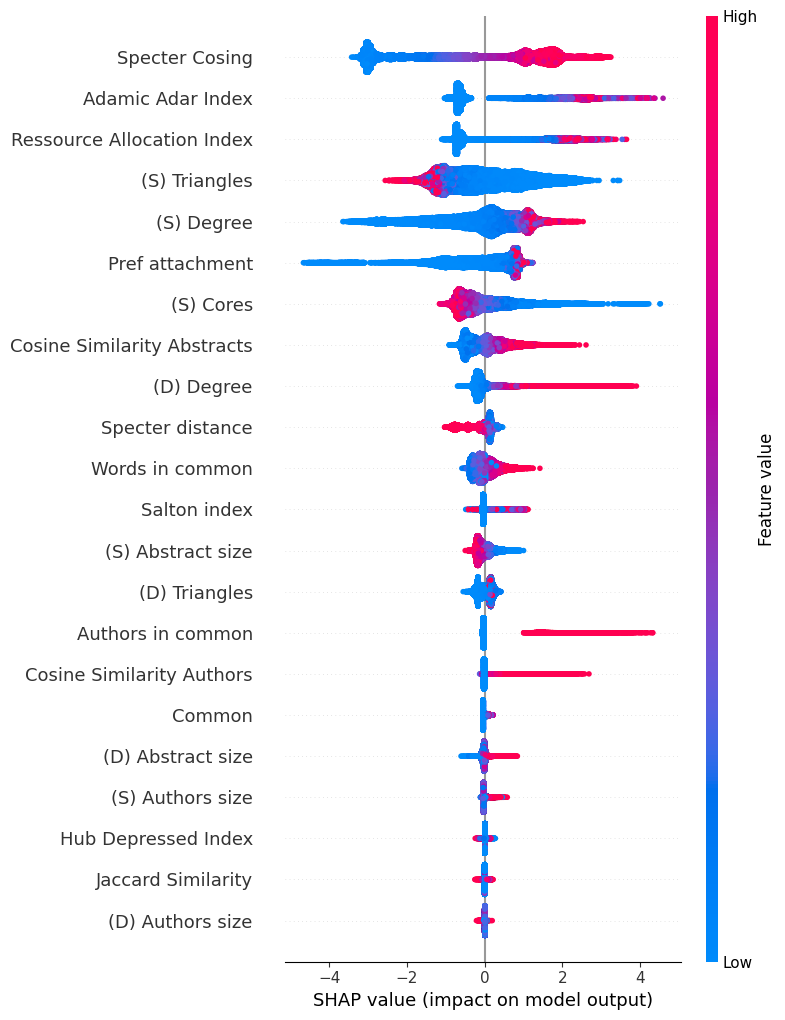

In [43]:
shap_values = shap.TreeExplainer(xbg).shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=X_train.shape[1], feature_names = feature_names)

In [230]:
print("Train labels:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Test labels:", dict(zip(*np.unique(y_test, return_counts=True))))

Train labels: {0.0: 1091955, 1.0: 1091955}
Test labels: {1.0: 106692}
